## Importing the necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Importing the data from phyphox application

In [2]:
dataframe = pd.read_csv("activity_recognition.csv", names = ["time", "accelerationX", "accelerationY", "accelerationZ", "accABS"], skiprows=[0])
print(dataframe)

print(dataframe.index[-1])

           time  accelerationX  accelerationY  accelerationZ  accABS
0        0.0000          -3.45           7.47           8.18   11.60
1        0.0100          -3.46           7.08           8.54   11.60
2        0.0201          -3.38           7.26           8.82   11.90
3        0.0301          -3.70           7.68           9.32   12.60
4        0.0402          -4.14           7.89           9.87   13.30
...         ...            ...            ...            ...     ...
12154  122.0000          -2.29           5.33           6.70    8.87
12155  122.0000          -2.09           4.80           6.39    8.26
12156  122.0000          -2.00           4.37           6.20    7.85
12157  122.0000          -1.85           4.43           6.09    7.75
12158  122.0000          -1.81           4.57           5.80    7.60

[12159 rows x 5 columns]
12158


In [3]:
# Rounding to two decimals the time column

dataframe["time"] = round(dataframe["time"], 2)
print(dataframe.head(20))

# Getting to know more our dataset

print(dataframe.info())

    time  accelerationX  accelerationY  accelerationZ  accABS
0   0.00         -3.450           7.47           8.18   11.60
1   0.01         -3.460           7.08           8.54   11.60
2   0.02         -3.380           7.26           8.82   11.90
3   0.03         -3.700           7.68           9.32   12.60
4   0.04         -4.140           7.89           9.87   13.30
5   0.05         -4.230           7.70          10.40   13.60
6   0.06         -3.920           7.15          10.80   13.50
7   0.07         -3.250           6.38          10.80   12.90
8   0.08         -2.460           5.48          10.60   12.10
9   0.09         -1.870           4.59          10.30   11.40
10  0.10         -1.450           3.82           9.86   10.70
11  0.11         -1.410           3.44           9.46   10.20
12  0.12         -1.680           3.38           9.32   10.10
13  0.13         -2.030           3.55           9.38   10.20
14  0.14         -2.370           3.85           9.48   10.50
15  0.15

## Plotting the time data against the absolute acceleration

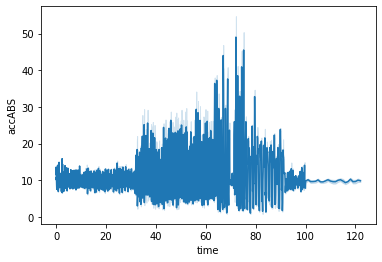

In [4]:
sns.lineplot(dataframe['time'], dataframe['accABS'])
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 16,10

## Obtaining the power peaks and power density which will be used as features for our supervised training model

In [5]:
def get_power_peaks(s):
    # Get power peaks
    # A power peak occurs after to changes in the line
    freqs, psd = signal.welch(s, fs=200, scaling='spectrum')
    current_diff = 0
    prev_diff = 0
    peak_freqs = []
    peak_psd = []
    for i in range(0, freqs.size):
        if i == 1:
            current_diff = psd[i] - psd[i - 1]
            
        if i > 1:
            prev_diff = current_diff
            current_diff = psd[i] - psd[i - 1]
        
        if np.sign(prev_diff) != np.sign(current_diff) and np.sign(prev_diff) == 1 and i > 0:
            peak_freqs.append(freqs[i - 1])
            peak_psd.append(psd[i - 1])
        
    sorted_idxs = (-np.array(peak_psd)).argsort()
    
    return sorted_idxs, peak_freqs, peak_psd

In [6]:
def plot_spectral_power_density(s):
    freqs, psd = signal.welch(s, fs=200, scaling='spectrum')
    sns.lineplot(np.log(freqs + 1), psd)

C:\Users\Alex\FinalAnaconda\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 254, using nperseg = 254
  .format(nperseg, input_length))


,start,end,max,min,avg,std,f0,p0,f1,p1,f2,p2
0,0,3,15.9,6.580,9.895385,2.027549,3.12500,2.390609,7.03125,0.170467,10.15625,0.078243
1,1.5,4.5,15.9,6.580,9.759431,1.914311,3.12500,2.066581,6.25000,0.269959,10.15625,0.190416
2,3,6,14.0,7.080,9.843423,1.627183,3.90625,1.999452,7.03125,0.059202,10.93750,0.054832
3,4.5,7.5,13.3,7.650,9.808997,1.407327,3.12500,1.410215,7.03125,0.048345,14.06250,0.030599
4,6,9,12.8,7.420,9.779398,1.500970,3.12500,1.710668,5.46875,0.059931,7.03125,0.044504
5,7.5,10.5,13.9,7.420,9.772585,1.579431,3.12500,1.779194,7.03125,0.089727,1.56250,0.060772
6,9,12,14.3,7.600,9.757449,1.598984,3.12500,1.387934,10.15625,0.067884,7.03125,0.050898
7,10.5,13.5,16.2,5.850,9.847291,1.971354,3.90625,2.176897,7.81250,0.239914,10.93750,0.165809
8,12,15,16.2,5.850,9.779331,2.046532,3.12500,2.756549,5.46875,0.078256,7.03125,0.062830
9,13.5,16.5,14.4,6.330,9.900468,2.054646,3.12500,2.419766,6.25000,0.071853,12.50000,0.029812


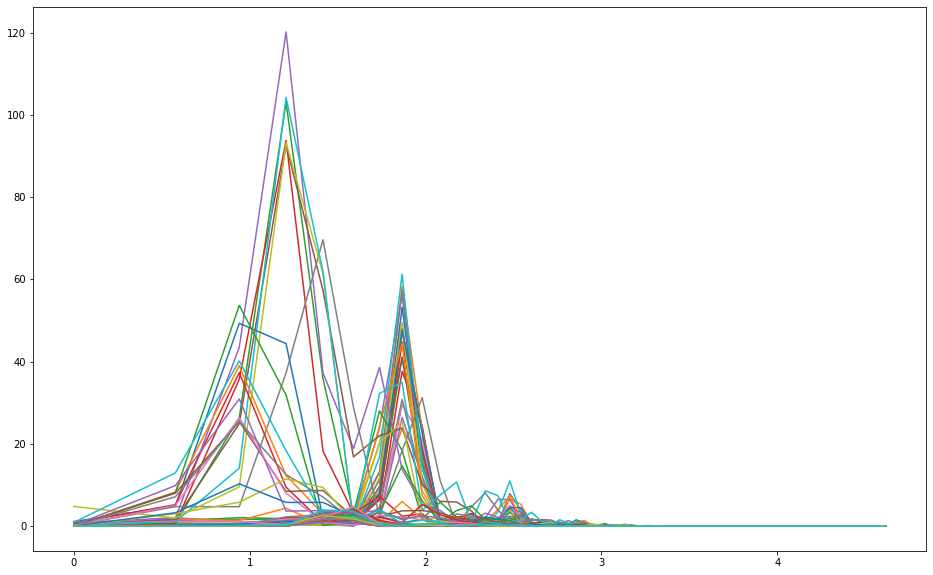

In [7]:
# Feature extraction
# This is the core of our program
# We will divide our dataset in windows of 3 seconds and and overlapping of 50%
window_size = 3
overlapping = 0.5  # % of the last window that overlaps the current window

# The list of features we are going to generate
allFeatures = ['start', 'end', 'max', 'min', 'avg', 'std', 'f0', 'p0', 'f1', 'p1', 'f2', 'p2']
#allFeatures = ['start', 'end', 'max', 'min', 'avg', 'std']

# New dataframe with the features
p_activity_df = pd.DataFrame(columns=allFeatures)

# start and end are the moment in seconds of starting and ending of each window
start = 0
end = start + window_size
while end <= dataframe.iloc[-1].time:
    # The window is the signal between start and end times
    window = dataframe[(dataframe['time'] >= start) & (dataframe['time'] < end)]
    
    # Get time domain features
    max = window.accABS.max()
    min = window.accABS.min()
    avg = window.accABS.mean()
    std = window.accABS.std()
    
    # Get frequency domain features
    sorted_idxs, peak_freqs, peak_psd = get_power_peaks(window.accABS)
    
    # Plot power an frequencies
    plot_spectral_power_density(window.accABS)
    
    # Write the features in the feature dataset
    row = pd.DataFrame([[\
        start,\
        end,\
        max,\
        min,\
        avg,\
        std,\
        peak_freqs[sorted_idxs[0]],\
        peak_psd[sorted_idxs[0]],\
        peak_freqs[sorted_idxs[1]],\
        peak_psd[sorted_idxs[1]],\
        peak_freqs[sorted_idxs[2]],\
        peak_psd[sorted_idxs[2]],\
    ]], columns=allFeatures)
    p_activity_df = p_activity_df.append(row)
    
    # Calculate the next window in the loop
    start = start + (end - start) * (1 - overlapping)
    end = start + window_size

p_activity_df.reset_index(inplace = True, drop = True)

p_activity_df.head(25)



In [8]:
p_activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 12 columns):
start    80 non-null object
end      80 non-null object
max      80 non-null float64
min      80 non-null float64
avg      80 non-null float64
std      80 non-null float64
f0       80 non-null float64
p0       80 non-null float64
f1       80 non-null float64
p1       80 non-null float64
f2       80 non-null float64
p2       80 non-null float64
dtypes: float64(10), object(2)
memory usage: 7.6+ KB


## Labeling the data


In [9]:
# Define a function to obtain the index of the change of activities (from 0 to 30 seconds - walking, from 30 to 60 seconds - running, from 60 to 90 seconds - jumping, from 90 to 122 - walking)

def get_index_of_the_end_of_activity(dataframe):
    
    list_of_times = [30, 60, 90]
    
    list_of_indexes = []
    
    for i in range(0, len(list_of_times)):
        
        list_of_indexes.append(p_activity_df.index[p_activity_df["start"] == list_of_times[i]])
    
    return list_of_indexes

print(get_index_of_the_end_of_activity(p_activity_df))

list_of_indices = get_index_of_the_end_of_activity(p_activity_df)

print(list_of_indices[0][0])

# Define a function that based on our list of indexes will label the data

def create_label_column(dataframe, list_of_indexes):
    
    dataframe["label"] = ""

    for i in range(0,list_of_indexes[0][0] + 1):
        dataframe["label"][i] = "walking"

    for i in range(list_of_indexes[0][0] + 1, list_of_indexes[1][0] + 1):
        dataframe["label"][i] = "running"

    for i in range(list_of_indexes[1][0] + 1, list_of_indexes[2][0] + 1):
        dataframe["label"][i] = "jumping"
        
    for i in range(list_of_indexes[2][0] + 1, dataframe.index[-1] + 1):
        dataframe["label"][i] = "walking"
    
    return dataframe

labeled_dataframe = create_label_column(p_activity_df, list_of_indices)

print(labeled_dataframe.tail(30))

[Int64Index([20], dtype='int64'), Int64Index([40], dtype='int64'), Int64Index([60], dtype='int64')]
20
    start    end   max    min        avg        std        f0         p0  \
50     75     78  54.5  0.568  11.874124  10.362099  1.562500  49.334903   
51   76.5   79.5  25.7  0.568  11.334090   7.565408  1.562500  39.023344   
52     78     81  36.5  1.530  14.223289   7.977143  1.562500  53.679493   
53   79.5   82.5  36.5  0.798  13.751378   7.760116  1.562500  37.318005   
54     81     84  26.1  0.370  11.739274   6.674559  1.562500  30.933500   
55   82.5   85.5  26.1  0.370  11.362554   6.495410  1.562500  25.427741   
56     84     87  22.5  1.110  11.563077   6.608691  1.562500  26.358098   
57   85.5   88.5  23.2  1.110  12.213478   6.143910  1.562500  25.493056   
58     87     90  24.7  0.595  12.036091   6.207859  2.343750  11.470169   
59   88.5   91.5  24.7  0.595  11.939013   6.264455  1.562500  40.161075   
60     90     93  23.8  1.060  11.050100   4.400747  1.562500

C:\Users\Alex\FinalAnaconda\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Alex\FinalAnaconda\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Alex\FinalAnaconda\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Alex\FinalAnaconda\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning

## Creating a correlation matrix to see the relationships between the features

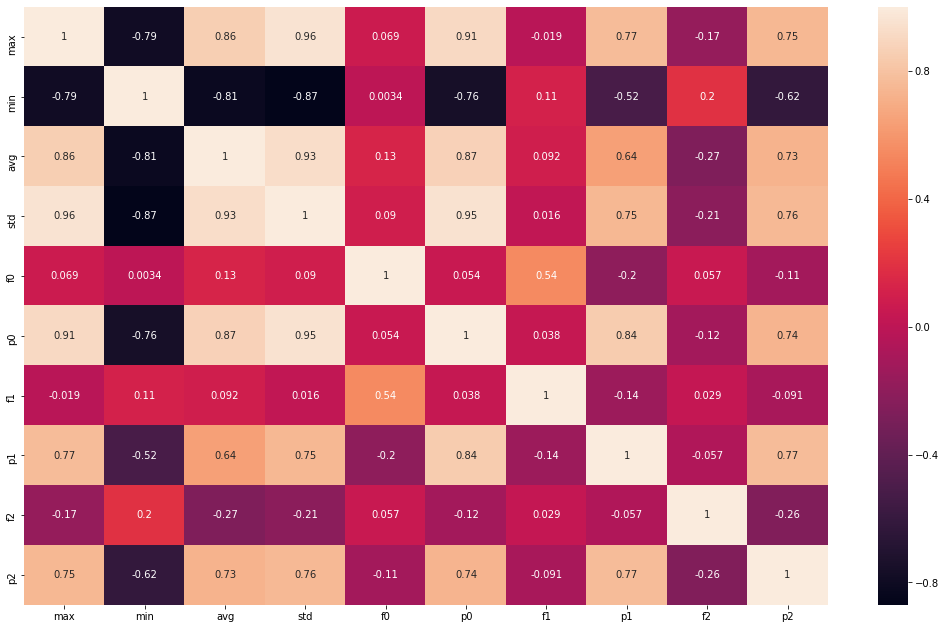

In [10]:
f, ax = plt.subplots(figsize=(18, 11))
correlation_matrix = labeled_dataframe.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

## Decision Tree Classifier taking into account all the features

In [11]:
X = labeled_dataframe.drop("label", axis = 1)
y = labeled_dataframe["label"]

split = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1)

# Create a model which will be used with tuned hyperparameters.
decision_tree_model = DecisionTreeClassifier( )

# 2 hyperparameters will be tuned --> max_depth, min_samples_leaf
parameters = {'max_depth': [2,3,4,5,6], "min_samples_leaf": [0.1, 0.12, 0.14, 0.16, 0.18]}

# Select the best hyperparameter value, based on NRMSE
decision_tree_cv = GridSearchCV(decision_tree_model, parameters, cv = split)

decision_tree_cv.fit(X,y)

# Create a model with the optimal hyperparameters
dt = DecisionTreeClassifier(max_depth = decision_tree_cv.best_params_['max_depth'], min_samples_leaf=decision_tree_cv.best_params_['min_samples_leaf'])


F1_scores= cross_val_score(dt, X, y, cv=split, 
                       scoring='f1_micro')

#Evaluate it
decision_tree_f1_cv_1 = (F1_scores.mean())

print("The CV F1-score of the decision tree classification model is: " ,decision_tree_f1_cv_1)

The CV F1-score of the decision tree classification model is:  0.9333333333333332


## KNeighbors Classifier model with all the features

In [12]:
X = labeled_dataframe.drop("label", axis = 1)
y = labeled_dataframe["label"]

split = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1)

# Create a model which will be used with tuned hyperparameters.
k_neighbors_model = KNeighborsClassifier()

# 2 hyperparameters will be tuned --> max_depth, min_samples_leaf
parameters = {'n_neighbors': [5,6,7,8]}

# Select the best hyperparameter value, based on NRMSE
k_neighbors_cv = GridSearchCV(k_neighbors_model, parameters, cv = split)

k_neighbors_cv.fit(X,y)

# Create a model with the optimal hyperparameters
KN = KNeighborsClassifier(n_neighbors = k_neighbors_cv.best_params_['n_neighbors'])


F1_scores= cross_val_score(KN, X, y, cv=split, 
                       scoring='f1_micro')

#Evaluate it
k_neighbors_f1_cv_1 = (F1_scores.mean())

print("The CV F1-score of the KNeighbors classifier model is: " ,k_neighbors_f1_cv_1)

The CV F1-score of the KNeighbors classifier model is:  0.975


## Logistic Regression taking into account all the features

In [13]:
X = labeled_dataframe.drop("label", axis = 1)
y = labeled_dataframe["label"]

split = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1)

lreg = LogisticRegression()

parameters = {"C": [0.01, 0.1, 0.3, 0.5, 1.0, 10, 100]}

# Select the best hyperparameter value, based on NRMSE
logistic_regression_cv = GridSearchCV(lreg, parameters, cv = split)

logistic_regression_cv.fit(X,y)

# Create a model with the optimal hyperparameters
lr = LogisticRegression(C = logistic_regression_cv.best_params_['C'])


F1_scores= cross_val_score(lr, X, y, cv=split, 
                       scoring='f1_micro')

#Evaluate it
logistic_regression_f1_cv_1 = (F1_scores.mean())

print("The CV F1-score of the LogisticRegression model is: " ,logistic_regression_f1_cv_1)


print(logistic_regression_cv.best_params_['C'])

C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarn

The CV F1-score of the LogisticRegression model is:  0.975
0.3


C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarn

## KNeighbors Classifier without taking into account std and p0

Here I am eliminating the features std and p0, because they have a great correlation with the max feature. Therefore, I thought that maybe they were explaining the same data and it should be worth a try eliminating them to see the performance of the different models without them.

In [14]:
X = labeled_dataframe.drop(["label", "std", "p0"], axis = 1)
y = labeled_dataframe["label"]

split = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1)

# Create a model which will be used with tuned hyperparameters.
k_neighbors_model = KNeighborsClassifier()

# 2 hyperparameters will be tuned --> max_depth, min_samples_leaf
parameters = {'n_neighbors': [5,6,7,8]}

# Select the best hyperparameter value, based on NRMSE
k_neighbors_cv = GridSearchCV(k_neighbors_model, parameters, cv = split)

k_neighbors_cv.fit(X,y)

# Create a model with the optimal hyperparameters
KN = KNeighborsClassifier(n_neighbors = k_neighbors_cv.best_params_['n_neighbors'])


F1_scores= cross_val_score(KN, X, y, cv=split, 
                       scoring='f1_micro')

#Evaluate it
k_neighbors_f1_cv_2 = (F1_scores.mean())

print("The CV F1-score of the KNeighborsClassifier model is: " , k_neighbors_f1_cv_2)

The CV F1-score of the KNeighborsClassifier model is:  0.9666666666666668


## DecisionTreeClassifier without taking into account std and p0

In [15]:
X = labeled_dataframe.drop(["label", "std", "p0"], axis = 1)
y = labeled_dataframe["label"]

split = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1)

# Create a model which will be used with tuned hyperparameters.
decision_tree_model = DecisionTreeClassifier( )

# 2 hyperparameters will be tuned --> max_depth, min_samples_leaf
parameters = {'max_depth': [2,3,4,5,6], "min_samples_leaf": [0.1, 0.12, 0.14, 0.16, 0.18]}

# Select the best hyperparameter value, based on NRMSE
decision_tree_cv = GridSearchCV(decision_tree_model, parameters, cv = split)

decision_tree_cv.fit(X,y)

# Create a model with the optimal hyperparameters
dt = DecisionTreeClassifier(max_depth = decision_tree_cv.best_params_['max_depth'], min_samples_leaf=decision_tree_cv.best_params_['min_samples_leaf'])


F1_scores= cross_val_score(dt, X, y, cv=split, 
                       scoring='f1_micro')

#Evaluate it
decision_tree_f1_cv_2 = (F1_scores.mean())

print("The CV F1-score of the DecisionTreeClassifier model is: " ,decision_tree_f1_cv_2)

The CV F1-score of the DecisionTreeClassifier model is:  0.9416666666666667


## Logistic Regression without taking into account std and p0

In [16]:
X = labeled_dataframe.drop(["label", "std", "p0"], axis = 1)
y = labeled_dataframe["label"]

split = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1)

lreg = LogisticRegression()

parameters = {"C": [0.01, 0.1, 0.3, 0.5, 1.0, 10, 100]}

# Select the best hyperparameter value, based on NRMSE
logistic_regression_cv = GridSearchCV(lreg, parameters, cv = split)

logistic_regression_cv.fit(X,y)

# Create a model with the optimal hyperparameters
lr = LogisticRegression(C = logistic_regression_cv.best_params_['C'])


F1_scores= cross_val_score(lr, X, y, cv=split, 
                       scoring='f1_micro')

#Evaluate it
logistic_regression_f1_cv_2 = (F1_scores.mean())

print("The CV F1-score of the LogisticRegression model is: " ,logistic_regression_f1_cv_2)

print(logistic_regression_cv.best_params_['C'])


C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarn

C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarn

The CV F1-score of the LogisticRegression model is:  0.975
0.1


C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alex\FinalAnaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [17]:
models_performance = [('Logistic Regression',logistic_regression_f1_cv_1, logistic_regression_f1_cv_2 ),
                     ('Decision Tree Classifier',decision_tree_f1_cv_1, decision_tree_f1_cv_2 ),
                     ('KNeighbors Classifier',k_neighbors_f1_cv_1, k_neighbors_f1_cv_2),
                     ]

models_performance_1 = sorted(models_performance, key = lambda x: x[1], reverse=True)

models_final_evaluation = pd.DataFrame(data = models_performance_1, columns=['Classification Model','CV F1 Score - all features', 'CV F1 Score - without std and p0'])
print(models_final_evaluation)

       Classification Model  CV F1 Score - all features  \
0       Logistic Regression                    0.975000   
1     KNeighbors Classifier                    0.975000   
2  Decision Tree Classifier                    0.933333   

   CV F1 Score - without std and p0  
0                          0.975000  
1                          0.966667  
2                          0.941667  


## Final conclusion

As it can be appreciated from the previous table, the model that performs better to classify the different activities is the Logistic Regression one, since it is the one where both its f1 cross-validated scores, are the highest, taking into account all the features and without taking into account **std** and **p0**. In order to keep improving this model, new features could be added or we could also calculate the GradientBoostingClassifier scores and see how they were, but because of time constraints I could not include it for this assignment.